# Randomization (part 1): a clever way to avoid the random sampling assumption

When comparing two means, we saw that the random sampling assumption allows us to compute the following statistics for two samples A and B of size $n_A$ and $n_B$: 
$$t = \frac{(\bar{y_B}-\bar{y_A}) - (\eta_B-\eta_A)}{s\sqrt{(1/n_A+1/n_B)}}$$

Unfortunately, the random sampling assumption is often not true because it implies that the data samples are independent. In many real life situations, like on a production line, data is consistently influenced by other parameters (e.g. temperature, raw material, training of operators), that can vary within days, weeks or months. So the data collected during a specific week may be skewed one way while the data collected during another week might be skewed another way, thus violating the random sampling model.

Increasing the sample size can circumvent this issue but it is usually too expensive, not practical, and sometimes not enough.

Randomization provides an elegant tool in the statistician's toolkit to address this issue. It offers a way to compare means without needing random sampling assumption. In essence, it shifts the randomization from the data to the experimenter, which is much easier to control.

In [17]:
import pandas as pd
import numpy as np
import math
import scipy.stats as st
import matplotlib.pyplot as plt
%config Completer.use_jedi = False
pd.set_option('display.max_rows', 500)
y_210 = pd.read_excel('yield 210.xlsx')
y_AB = pd.read_excel('yield 20.xlsx')

## The tomato plant experiment

Goal is to discover whether change in fertilizer mixture applied to tomato plants would result in an improved yield. This is the same issue as before. We are still comparing two means:
- 11 plants set out in a single row
- 5 given the standard fertilizer A
- 6 given supposedly improved fertilizer B
- A's and B's randomly applied to the positions in the row to give the following design

In [18]:
df = pd.DataFrame({'fertilizer':list('AABBABBBAAB'),
                  'yield':[29.9,11.4,26.6,23.7,25.3,28.5,14.2,17.9,16.5,21.1,24.3]},
                  index=np.arange(1,12))
df.index.name = 'position'
y_Abar = df[df['fertilizer']=='A']['yield'].mean(axis=0)
y_Bbar = df[df['fertilizer']=='B']['yield'].mean(axis=0)
print('y_Abar is: {:.02f}, y_Bbar is: {:.02f}, and difference is {:.02f}'.format(y_Abar,y_Bbar,y_Bbar-y_Abar))
df

y_Abar is: 20.84, y_Bbar is: 22.53, and difference is 1.69


,fertilizer,yield
position,,
1,A,29.9
2,A,11.4
3,B,26.6
4,B,23.7
5,A,25.3
6,B,28.5
7,B,14.2
8,B,17.9
9,A,16.5


### Randomization

To randomize the experiment, we assume that the label A or B have no influence on the yield of the plant, and can thus be moved around without affecting the yield. This is our null hypothesis.

So we compute the difference of sample average between method A and B for each permutation of the labels. There are ${11 \choose 5} = 11!/5!6! = 462$ permutations. Then we compare the original difference of sample mean 1.69 to all the 461 remaining differences of sample means to determine if 1.69 is an extreme value or not, using the traditional p value concept. If p value is below 5%, we conclude the null hypothesis is not true.

there are 154 combinations, representing 33.33% of the 462 combinations, with mean higher than 1.69


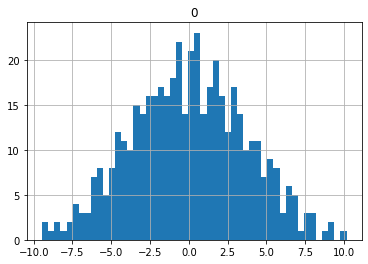

In [19]:
import itertools
diff = []
for v in itertools.combinations(df.index,5):
    y_A = df.loc[list(v),'yield'].mean(axis=0)
    y_B = df.loc[list(set(df.index)-set(v)),'yield'].mean(axis=0)
    diff.append(y_B - y_A)
pd.DataFrame(diff).hist(bins=50)
sum(np.array(diff) > 1.69)
print('there are {} combinations, representing {:.02f}% of the 462 combinations, with mean higher than 1.69'.format(sum(np.array(diff) > 1.69), 100*sum(np.array(diff) > 1.69)/462))

### Traditional t test with random sampling assumption

In [20]:
# we need to compute the t statistic
# first we need the pooled variance s
s_sq = (1/9)*(sum((df[df['fertilizer']=='A']['yield'] - y_Abar)**2) + sum((df[df['fertilizer']=='B']['yield'] - y_Bbar)**2))
t = ((y_Bbar - y_Abar) - 0)/math.sqrt(s_sq*(1/5+1/6))
p_value = 1 - st.t.cdf(t,df=9,loc=0,scale=1)
print('assuming random sampling assumption and t statistic, sample pooled variance is {:.02f}, t is {:.02f}, p value is {:0.2f}'
      .format(s_sq,t,p_value))


assuming random sampling assumption and t statistic, sample pooled variance is 39.73, t is 0.44, p value is 0.33


As we can see, the resulting p value for the randomization approach and t test approach are very similar.

It can be shown that the randomization reference distribution can be reasonably approximated by the appropriately scaled t distribution. 

Thus, provided we randomize, we can employ t tests as appromixations of exact randomization and free ourselves from the constraining assumptions of 1) random sampling and 2) normality of the reference population